<table>
<td>
<img src="https://people.iee.ihu.gr/~kdiamant/images/kdiamantaras2.jpg" alt="Kostas Diamantaras" height="100"/>
</td>
<td>
<p>Konstantinos Diamantaras</p>
<p>Department of Information and Electronic Engineering</p>  
<p>International Hellenic University</p>  
<p>Greece</p>
</td>
<td>
<img src="https://people.iee.ihu.gr/~kdiamant/images/International_Hellenic_University_logo.jpg" alt="Kostas Diamantaras" height="100"/>
</td>
</table>

# ResNet-20 for image recognition  
<ul>
<li> Build and train the model</li>
<li> Demonstrate callbacks, learning rate scheduling, plotting utilities</li>
<li> Predict test patterns</li>
<li> Dataset: <a href="https://www.cs.toronto.edu/~kriz/cifar.html">CIFAR10</a></li>
</ul>

In [ ]:
from __future__ import print_function
import keras
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Concatenate, \
                                    AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os
import time
from numpy.linalg import inv, norm

np.set_printoptions(suppress=True, precision=3)

from google.colab import drive

drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/')
print(os.getcwd())
save_dir = os.path.join(os.getcwd(), 'saved_models')

!nvidia-smi

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks
Fri Nov 13 07:15:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |    755MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR

Load CIFAR10 data

In [ ]:
depth=20

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_classes = 10

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


# Convert class vectors to binary class matrices.
t_train = keras.utils.to_categorical(y_train, num_classes)
t_test = keras.utils.to_categorical(y_test, num_classes)

print('y_train (labels) shape:', y_train.shape)
print('t_train (one-hot rep) shape:', t_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train (labels) shape: (50000, 1)
t_train (one-hot rep) shape: (50000, 10)


---
ResNet block

In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

ResNet version 1

In [ ]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=2, ### originally: 1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    print('Model parameters: {:d}'.format(model.count_params()))
    return model

---

Learning rate schedule

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    return lr

Callback for epoch monitoring

In [ ]:
'''
Epoch monitoring: Print info at every epoch
'''

class MyCallback(keras.callbacks.Callback):
    tstart = None
    def on_train_begin(self, logs={}):
        return
    
    def on_train_end(self, logs={}):
        return
    
    def on_epoch_begin(self, epoch, logs={}):
        self.tstart = time.time()
        print('epoch:{:03d}'.format(epoch+1), end=', ')
        return
    
    def on_epoch_end(self, epoch, logs={}):
        print('loss:{:8.6f}, acc:{:8.6f},  val_loss:{:8.6f}, val_acc:{:8.6f},  val_acc-acc = {:5.2f}%,  lr:{:0.6f}  [{:0.2f} sec]'.format(
                logs.get('loss'), logs.get('acc'),
                logs.get('val_loss'), logs.get('val_acc'),
                100*(logs.get('val_acc')-logs.get('acc')),
                K.eval(self.model.optimizer.lr),
                time.time()-self.tstart))
        return
    
    def on_batch_begin(self, batch, logs={}):
        return
    
    def on_batch_end(self, batch, logs={}):
        return

---
### Training

In [ ]:
model = resnet_v1(input_shape=input_shape, depth=depth)
    
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['acc'])
model.summary()

Model parameters: 282122
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 32, 32, 16)   64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 32, 32, 16)   0           batch_normalization_19[0][0]     
______________________________________________________________

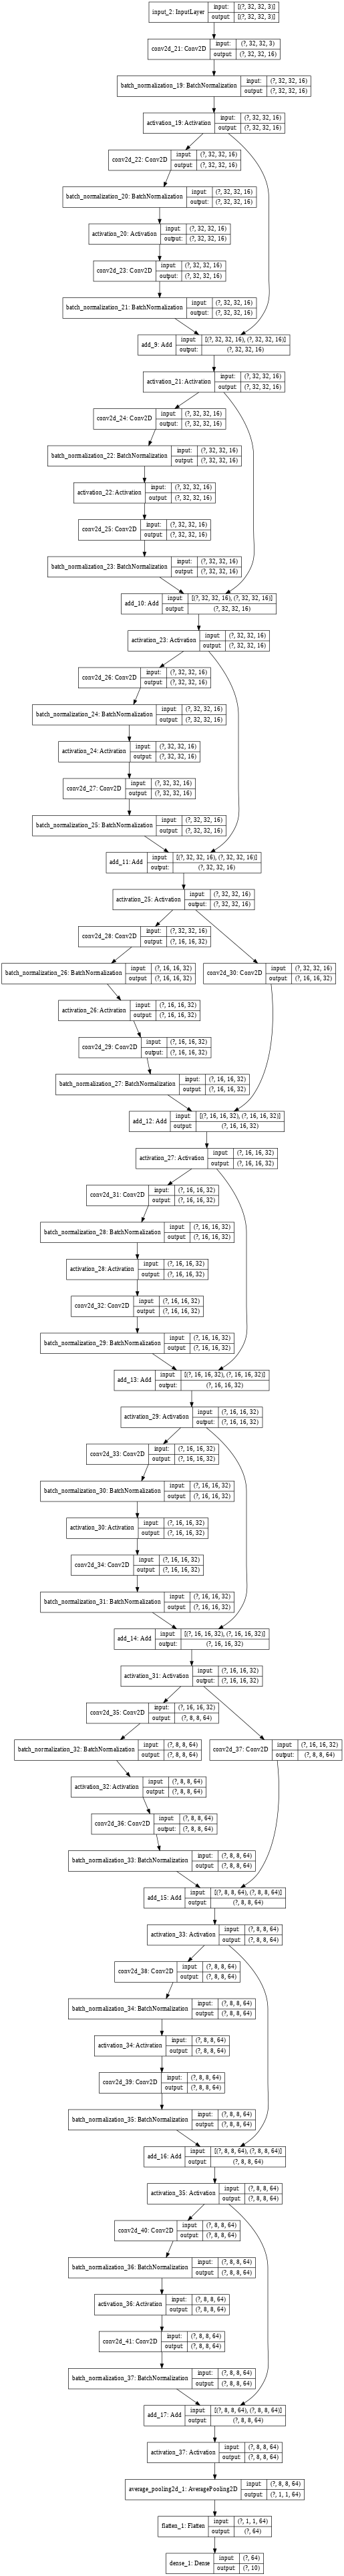

In [ ]:
plot_model(model, show_shapes=True, dpi=48)

In [ ]:
'''
The Model object has the following attributes
['_uses_inputs_arg', 'inputs', 'outputs', 'name', 'trainable',
'_is_compiled', '_expects_training_arg', '_initial_weights', 'supports_masking', 'optimizer',
'_updates', '_losses', '_per_input_losses', '_per_input_updates', '_layers',
'_outbound_nodes', '_inbound_nodes', '_compute_previous_mask', '_built', '_is_graph_network',
'_input_layers', '_output_layers', '_input_coordinates', '_output_coordinates', '_output_mask_cache',
'_output_tensor_cache', '_output_shape_cache', '_network_nodes', '_nodes_by_depth', '_layers_by_depth',
'input_names', 'output_names', '_feed_input_names', '_feed_inputs', '_feed_input_shapes',
'loss', 'metrics', 'loss_weights', 'sample_weight_mode', 'weighted_metrics',
'loss_functions', '_feed_outputs', '_feed_output_names', '_feed_output_shapes', '_feed_loss_fns',
'targets', '_feed_targets', 'sample_weight_modes', '_feed_sample_weight_modes', 'metrics_names',
'metrics_tensors', 'metrics_updates', 'stateful_metric_names', 'stateful_metric_functions', 'total_loss',
'sample_weights', '_feed_sample_weights', '_function_kwargs', 'train_function', 'test_function',
'predict_function', '_collected_trainable_weights', 'history', 'stop_training'])
'''
for layer in range(len(model._layers)):
    layer_obj = model._layers[layer]
    print('{}'.format(layer_obj.name))

input_2
conv2d_21
batch_normalization_19
activation_19
conv2d_22
batch_normalization_20
activation_20
conv2d_23
batch_normalization_21
add_9
activation_21
conv2d_24
batch_normalization_22
activation_22
conv2d_25
batch_normalization_23
add_10
activation_23
conv2d_26
batch_normalization_24
activation_24
conv2d_27
batch_normalization_25
add_11
activation_25
conv2d_28
batch_normalization_26
activation_26
conv2d_29
conv2d_30
batch_normalization_27
add_12
activation_27
conv2d_31
batch_normalization_28
activation_28
conv2d_32
batch_normalization_29
add_13
activation_29
conv2d_33
batch_normalization_30
activation_30
conv2d_34
batch_normalization_31
add_14
activation_31
conv2d_35
batch_normalization_32
activation_32
conv2d_36
conv2d_37
batch_normalization_33
add_15
activation_33
conv2d_38
batch_normalization_34
activation_34
conv2d_39
batch_normalization_35
add_16
activation_35
conv2d_40
batch_normalization_36
activation_36
conv2d_41
batch_normalization_37
add_17
activation_37
average_pooling2d

In [ ]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200

# Prepare model model saving directory.
model_name = 'resnet20-e{epoch:04d}-loss{loss:.3f}-acc{acc:.3f}-valloss{val_loss:.3f}-valacc{val_acc:.3f}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
history = model.fit(datagen.flow(x_train, t_train, batch_size=batch_size),
                                validation_data=(x_test, t_test),
                                epochs=epochs, verbose=0, workers=4,
                                steps_per_epoch = int(x_train.shape[0]/batch_size),
                                callbacks=[lr_reducer, lr_scheduler, MyCallback(), checkpoint])


# Score trained model.
scores = model.evaluate(x_test, t_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

epoch:001, loss:1.590865, acc:0.482289,  val_loss:1.359819, val_acc:0.570400,  val_acc-acc =  8.81%,  lr:0.001000  [37.00 sec]

Epoch 00001: val_acc improved from -inf to 0.57040, saving model to /content/gdrive/My Drive/Colab Notebooks/saved_models/resnet20-e0001-loss1.591-acc0.482-valloss1.360-valacc0.570.h5
epoch:002, loss:1.192608, acc:0.632785,  val_loss:1.224879, val_acc:0.633800,  val_acc-acc =  0.10%,  lr:0.001000  [34.36 sec]

Epoch 00002: val_acc improved from 0.57040 to 0.63380, saving model to /content/gdrive/My Drive/Colab Notebooks/saved_models/resnet20-e0002-loss1.193-acc0.633-valloss1.225-valacc0.634.h5
epoch:003, loss:1.026093, acc:0.696286,  val_loss:1.082270, val_acc:0.678000,  val_acc-acc = -1.83%,  lr:0.001000  [34.21 sec]

Epoch 00003: val_acc improved from 0.63380 to 0.67800, saving model to /content/gdrive/My Drive/Colab Notebooks/saved_models/resnet20-e0003-loss1.026-acc0.696-valloss1.082-valacc0.678.h5
epoch:004, loss:0.927984, acc:0.733029,  val_loss:1.054863

### Plot results


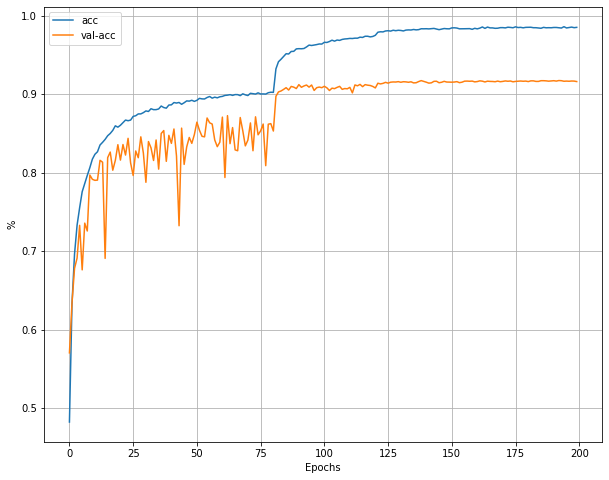

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend(('acc','val-acc'))
plt.grid(b=True)